# **1. Data Acquisition**

1.1 Import Library and Dataset from Kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mostafaabla/garbage-classification

 98% 235M/239M [00:08<00:00, 34.4MB/s]
100% 239M/239M [00:08<00:00, 29.5MB/s]


In [4]:
import os

In [5]:
!unzip garbage-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classific

#Importing packages

In [6]:
!pip install --upgrade tensorflow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re
import cv2

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


In [8]:
# Mendefinisikan jalur dataset
path = '/content/garbage_classification'

# **2. Data Visualization**

In [9]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/garbage_classification/"

# 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('Kategori Success !')

Kategori Success !


In [10]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('Jumlah Dataset = ' , len(df), 'Data')

Jumlah Dataset =  15515 Data


In [11]:
df

,filename,category
0,biological/biological299.jpg,11
1,clothes/clothes2589.jpg,7
2,cardboard/cardboard307.jpg,1
3,white-glass/white-glass541.jpg,10
4,cardboard/cardboard507.jpg,1
...,...,...
15510,brown-glass/brown-glass458.jpg,9
15511,plastic/plastic863.jpg,2
15512,paper/paper592.jpg,0
15513,battery/battery720.jpg,5


Jumlah sampel dalam setiap kelas:
{'white-glass': 775, 'brown-glass': 607, 'shoes': 1977, 'metal': 769, 'plastic': 865, 'clothes': 5325, 'paper': 1050, 'green-glass': 629, 'trash': 697, 'battery': 945, 'biological': 985, 'cardboard': 891}


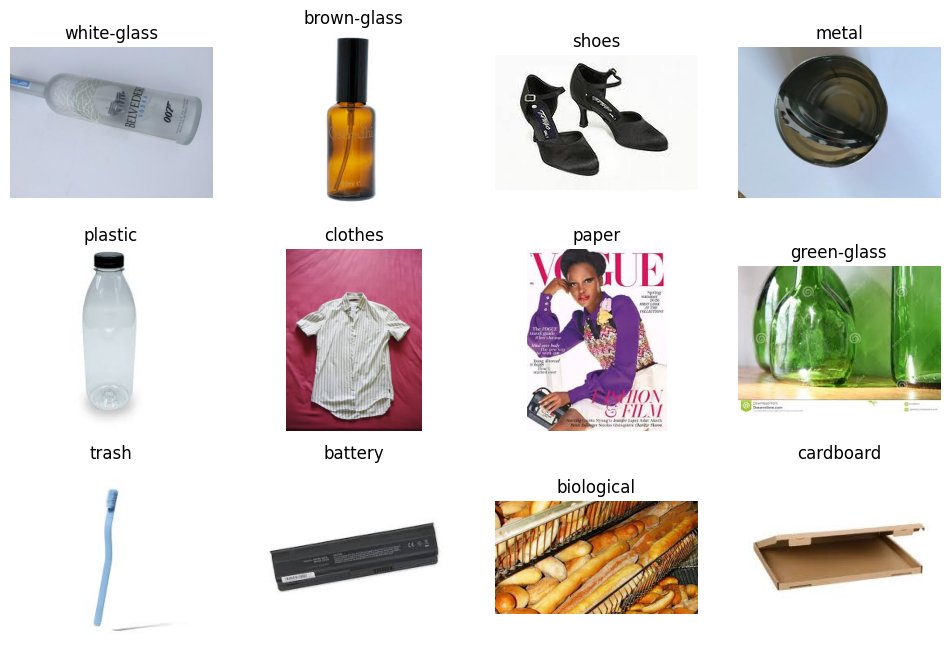

In [12]:
# Melihat jumlah sampel dalam setiap kelas
class_counts = {}
for class_folder in os.listdir('/content/garbage_classification'):
    if os.path.isdir(os.path.join('/content/garbage_classification', class_folder)):
        class_counts[class_folder] = len(os.listdir(os.path.join('/content/garbage_classification', class_folder)))
print("Jumlah sampel dalam setiap kelas:")
print(class_counts)

# Visualisasi sampel gambar
plt.figure(figsize=(12, 8))
class_folders = list(class_counts.keys())
for i, class_folder in enumerate(class_folders):
    image_files = os.listdir(os.path.join('/content/garbage_classification', class_folder))
    sample_image = cv2.imread(os.path.join('/content/garbage_classification', class_folder, image_files[0]))
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 4, i+1)
    plt.imshow(sample_image)
    plt.title(class_folder)
    plt.axis('off')

plt.show()

white-glass/white-glass366.jpg


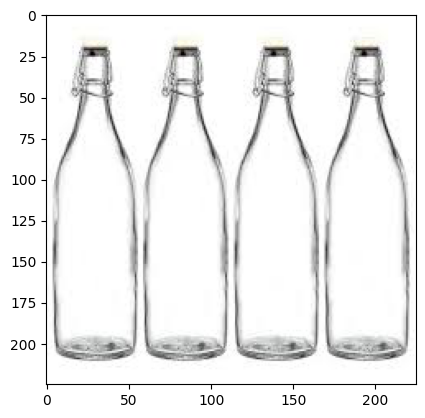

In [13]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

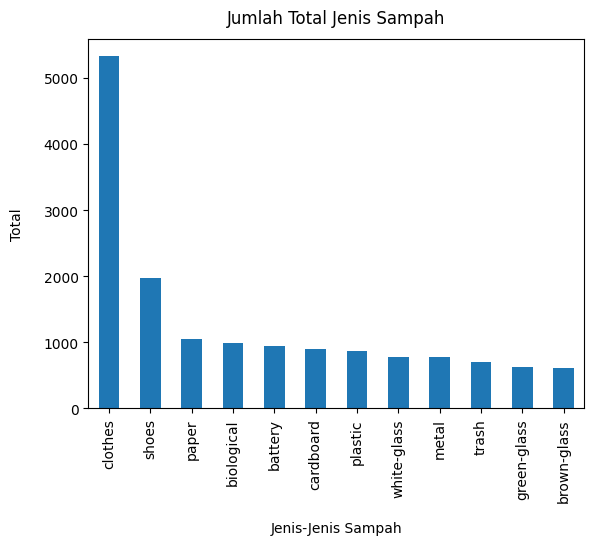

In [14]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Jenis-Jenis Sampah", labelpad=14)
plt.ylabel("Total", labelpad=14)
plt.title("Jumlah Total Jenis Sampah", y=1.02);

In [15]:
folder_names = []
num_images = []

# Loop melalui setiap folder dalam direktori dataset
for folder_name in os.listdir('/content/garbage_classification'):
    folder_path = os.path.join('/content/garbage_classification', folder_name)
    
    # Hanya memeriksa folder (bukan file)
    if os.path.isdir(folder_path):
        image_files = [file for file in os.listdir(folder_path) if file.endswith(('jpg', 'jpeg', 'png', 'gif'))]
        
        folder_names.append(folder_name)
        num_images.append(len(image_files))

total_images = sum(num_images)
data = {'Folder': folder_names, 'Jumlah Gambar': num_images}
df = pd.DataFrame(data)
total_row = pd.DataFrame({'Folder': ['Total'], 'Jumlah Gambar': [total_images]})
df = pd.concat([df, total_row], ignore_index=True)
df

,Folder,Jumlah Gambar
0,white-glass,775
1,brown-glass,607
2,shoes,1977
3,metal,769
4,plastic,865
5,clothes,5325
6,paper,1050
7,green-glass,629
8,trash,697
9,battery,945


# **3. Pre-Processing Data**

In [16]:
from PIL import Image
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import RandomOverSampler

In [17]:
# Membuat data generator dengan augmentasi data
train_data_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True
)

validation_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [18]:
# Membagi dataset menjadi data latih dan data validasi
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [19]:
# Mendefinisikan parameter model
input_shape = (224, 224, 3)
num_classes = len(os.listdir('/content/garbage_classification'))
batch_size = 32
epochs = 25

In [20]:
# Membuat generator data
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/content/garbage_classification',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/garbage_classification',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


# **3.1 Training Model**

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet201

In [29]:
# Membangun model CNN
def make_model():
    ModelDenseNet201 = tf.keras.models.Sequential([
        tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),
                                          include_top=False,
                                          pooling='max',
                                          weights='imagenet'),
        # tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='ReLU'),
        tf.keras.layers.Dense(128, activation='ReLU'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='ReLU'),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(12, activation='softmax')
    ])
    return ModelDenseNet201
# densnet = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3),
#                                            include_top=False,
#                                            weights='imagenet')

# model = Sequential()
# model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=input_shape))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
# model.add(MaxPooling2D((2, 2)))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

In [33]:
# Membuat model
model = make_model()

# Mengompilasi model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_3 (Flatten)         (None, 1920)              0         
                                                                 
 dropout_6 (Dropout)         (None, 1920)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               491776    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)               

In [34]:

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epoch s,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/25
387/387 [==============================] - 302s 627ms/step - loss: 2.9333 - accuracy: 0.2243 - val_loss: 1.8922 - val_accuracy: 0.3942
Epoch 2/25
387/387 [==============================] - 229s 590ms/step - loss: 1.9921 - accuracy: 0.3791 - val_loss: 1.5647 - val_accuracy: 0.4792
Epoch 3/25
387/387 [==============================] - 228s 590ms/step - loss: 1.6928 - accuracy: 0.4526 - val_loss: 1.3725 - val_accuracy: 0.5576
Epoch 4/25
387/387 [==============================] - 229s 591ms/step - loss: 1.5156 - accuracy: 0.5123 - val_loss: 1.2265 - val_accuracy: 0.6221
Epoch 5/25
387/387 [==============================] - 229s 591ms/step - loss: 1.3729 - accuracy: 0.5579 - val_loss: 1.1123 - val_accuracy: 0.6680
Epoch 6/25
387/387 [==============================] - 224s 577ms/step - loss: 1.2304 - accuracy: 0.6031 - val_loss: 1.0108 - val_accuracy: 0.7044
Epoch 7/25
387/387 [==============================] - 223s 577ms/step - loss: 1.1310 - accuracy: 0.6405 - val_loss: 0.9220 -

# **4. Evaluation and Validation Model**

In [35]:
model.evaluate(validation_generator)
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

97/97 [==============================] - 18s 156ms/step


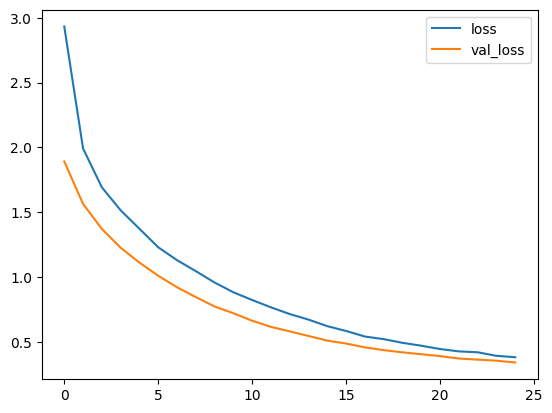

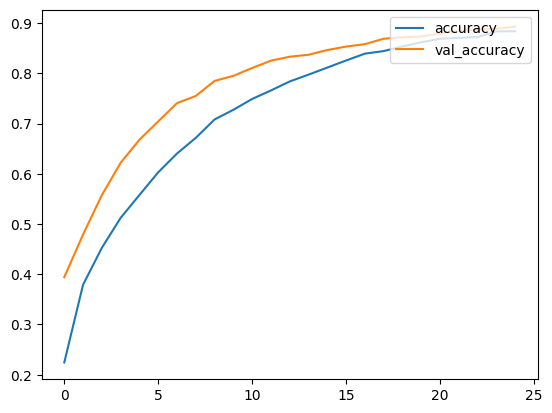

In [36]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

# **5. Testing Model**

In [37]:
# Menyimpan model
model.save('2garbage_classification_model.h5')


===================

1/1 [==============================] - 3s 3s/step


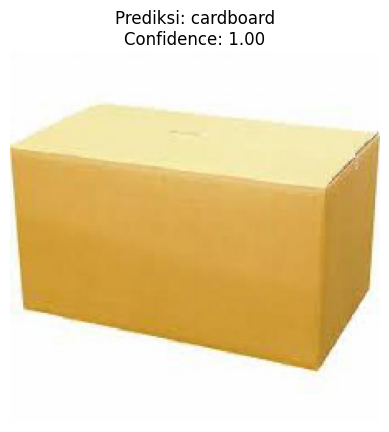

In [42]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Memuat model yang telah dilatih
model = keras.models.load_model('/content/2garbage_classification_model.h5')

# Path file gambar yang akan diprediksi
image_path = '/content/cardboard103_jpg.rf.85bcb557bc186486d9f28d755ef19002.jpg'

# Mengubah gambar menjadi format yang dapat digunakan oleh model
img = image.load_img(image_path, target_size=(224, 224, 3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Melakukan prediksi
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

# Menampilkan hasil prediksi
class_labels = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']  # Ganti dengan daftar label kelas Anda
predicted_label = class_labels[predicted_class]

# Menampilkan gambar dan hasil prediksi
plt.imshow(img)
plt.axis('off')
plt.title('Prediksi: {}\nConfidence: {:.2f}'.format(predicted_label, confidence))
plt.show()


# **6. Deployment**